In [ ]:
import numpy as np
import pandas as pd
import torch

In [ ]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
from datasets import load_dataset

ds = load_dataset("tdavidson/hate_speech_offensive")

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 24783
    })
})

In [ ]:
tdavidson = pd.DataFrame(ds['train'])

In [ ]:
tdavidson = tdavidson[:2000]

In [ ]:
len(tdavidson)

24783

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from datasets import load_dataset

# Load the tweet_hate dataset
# ds = load_dataset("cardiffnlp/super_tweeteval", "tweet_hate")

# # Convert the 'test' split to a pandas DataFrame
# df = pd.DataFrame(ds['test'])

# Initialize label mappings
label_mappings = {
    "facebook_roberta": {0: 'Neutral', 1: 'Hate'},
    "hatexplain": {0: 'Hate', 1: 'Neutral', 2: 'Offensive'},
    "distilroberta": {0: 'Hate', 1: 'Offensive', 2: 'Neutral'},
    "cardiff_roberta": {0: "hate_gender", 1: "hate_race", 2: "hate_sexuality",
                        3: "hate_religion", 4: "hate_origin", 5: "hate_disability",
                        6: "hate_age", 7: "Neutral"},
    "dehatebert": {0: 'Neutral', 1: 'Hate'}
}

# Initialize the list of models
models = {
    "facebook_roberta": "facebook/roberta-hate-speech-dynabench-r4-target",
    "hatexplain": "Hate-speech-CNERG/bert-base-uncased-hatexplain",
    "distilroberta": "badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification",
    "cardiff_roberta": "cardiffnlp/twitter-roberta-large-hate-latest",
    "dehatebert": "Hate-speech-CNERG/dehatebert-mono-english",
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to run each model and get predictions, with offloading after each model
def run_model(model_name, model_path, text_list):
    print(f"Running model: {model_name}")

    # Tokenize the input text and move it to the GPU
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Load the model and tokenizer and Move the model to the GPU
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model = model.to(device)

    def print_memory_usage(message):
        allocated_memory = torch.cuda.memory_allocated(device) / 1024**3  # Convert to GB
        cached_memory = torch.cuda.memory_reserved(device) / 1024**3  # Convert to GB
        print(f"{message}: Allocated: {allocated_memory:.2f} GB, Cached: {cached_memory:.2f} GB")

    predictions_list = []
    batch_size = 32
    for i in range(0, len(text_list), batch_size):
        batch_text = text_list[i:i + batch_size]
        inputs = tokenizer(batch_text, padding=True, truncation=True, return_tensors="pt").to(device)

        # inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
        inputs = inputs.to(device)

        print_memory_usage("Before running model")

        # Run inference with no gradients
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the predicted probabilities and labels
        probabilities = torch.softmax(outputs.logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1)

        print_memory_usage("After running model")

        # Convert predictions to a list of label names
        predictions_list.extend(predictions.tolist())


    # Offload the model to the CPU
    model = model.to('cpu')
    torch.cuda.empty_cache()  # Clear GPU cache after offloading
    print_memory_usage("After offloading model to CPU and clearing cache")
    label_list = [label_mappings[model_name][pred] for pred in predictions_list]
    return label_list

# Run all models and append the predictions as new columns to the DataFrame
for model_name, model_path in tqdm(models.items(), desc="Running models"):
    tdavidson[model_name] = run_model(model_name, model_path, tdavidson['tweet'].tolist())

# Display the updated DataFrame with model predictions
tdavidson.head()


Running models:   0%|                                                                                                                                                                | 0/5 [00:00<?, ?it/s]

Running model: facebook_roberta
Before running model: Allocated: 0.47 GB, Cached: 0.52 GB
After running model: Allocated: 0.47 GB, Cached: 0.60 GB
Before running model: Allocated: 0.47 GB, Cached: 0.60 GB
After running model: Allocated: 0.47 GB, Cached: 0.67 GB
Before running model: Allocated: 0.47 GB, Cached: 0.67 GB
After running model: Allocated: 0.47 GB, Cached: 0.67 GB
Before running model: Allocated: 0.47 GB, Cached: 0.67 GB
After running model: Allocated: 0.47 GB, Cached: 0.67 GB
Before running model: Allocated: 0.47 GB, Cached: 0.67 GB
After running model: Allocated: 0.47 GB, Cached: 0.67 GB
Before running model: Allocated: 0.47 GB, Cached: 0.67 GB
After running model: Allocated: 0.47 GB, Cached: 0.67 GB
Before running model: Allocated: 0.47 GB, Cached: 0.67 GB
After running model: Allocated: 0.47 GB, Cached: 0.67 GB
Before running model: Allocated: 0.47 GB, Cached: 0.67 GB
After running model: Allocated: 0.47 GB, Cached: 0.67 GB
Before running model: Allocated: 0.47 GB, Cached

Running models:  20%|██████████████████████████████▍                                                                                                                         | 1/5 [00:34<02:16, 34.10s/it]

After offloading model to CPU and clearing cache: Allocated: 0.01 GB, Cached: 0.02 GB
Running model: hatexplain


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Before running model: Allocated: 0.42 GB, Cached: 0.46 GB
After running model: Allocated: 0.50 GB, Cached: 0.67 GB
Before running model: Allocated: 0.50 GB, Cached: 0.67 GB
After running model: Allocated: 0.57 GB, Cached: 0.95 GB
Before running model: Allocated: 0.57 GB, Cached: 0.95 GB
After running model: Allocated: 0.53 GB, Cached: 0.95 GB
Before running model: Allocated: 0.53 GB, Cached: 0.95 GB
After running model: Allocated: 0.48 GB, Cached: 0.95 GB
Before running model: Allocated: 0.48 GB, Cached: 0.95 GB
After running model: Allocated: 0.50 GB, Cached: 0.95 GB
Before running model: Allocated: 0.50 GB, Cached: 0.95 GB
After running model: Allocated: 0.49 GB, Cached: 0.95 GB
Before running model: Allocated: 0.49 GB, Cached: 0.95 GB
After running model: Allocated: 0.48 GB, Cached: 0.95 GB
Before running model: Allocated: 0.48 GB, Cached: 0.95 GB
After running model: Allocated: 0.52 GB, Cached: 0.95 GB
Before running model: Allocated: 0.52 GB, Cached: 0.95 GB
After running model: A

Running models:  40%|████████████████████████████████████████████████████████████▊                                                                                           | 2/5 [01:07<01:40, 33.57s/it]

After offloading model to CPU and clearing cache: Allocated: 0.03 GB, Cached: 0.11 GB
Running model: distilroberta
Before running model: Allocated: 0.32 GB, Cached: 0.33 GB
After running model: Allocated: 0.32 GB, Cached: 0.41 GB
Before running model: Allocated: 0.32 GB, Cached: 0.41 GB
After running model: Allocated: 0.32 GB, Cached: 0.48 GB
Before running model: Allocated: 0.32 GB, Cached: 0.48 GB
After running model: Allocated: 0.32 GB, Cached: 0.48 GB
Before running model: Allocated: 0.32 GB, Cached: 0.48 GB
After running model: Allocated: 0.32 GB, Cached: 0.48 GB
Before running model: Allocated: 0.32 GB, Cached: 0.48 GB
After running model: Allocated: 0.32 GB, Cached: 0.48 GB
Before running model: Allocated: 0.32 GB, Cached: 0.48 GB
After running model: Allocated: 0.32 GB, Cached: 0.48 GB
Before running model: Allocated: 0.32 GB, Cached: 0.48 GB
After running model: Allocated: 0.32 GB, Cached: 0.48 GB
Before running model: Allocated: 0.32 GB, Cached: 0.48 GB
After running model: A

Running models:  60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 3/5 [01:26<00:53, 26.91s/it]

After offloading model to CPU and clearing cache: Allocated: 0.01 GB, Cached: 0.02 GB
Running model: cardiff_roberta
Before running model: Allocated: 1.33 GB, Cached: 1.34 GB
After running model: Allocated: 1.33 GB, Cached: 1.43 GB
Before running model: Allocated: 1.33 GB, Cached: 1.43 GB
After running model: Allocated: 1.33 GB, Cached: 1.52 GB
Before running model: Allocated: 1.33 GB, Cached: 1.52 GB
After running model: Allocated: 1.33 GB, Cached: 1.52 GB
Before running model: Allocated: 1.33 GB, Cached: 1.52 GB
After running model: Allocated: 1.33 GB, Cached: 1.52 GB
Before running model: Allocated: 1.33 GB, Cached: 1.52 GB
After running model: Allocated: 1.33 GB, Cached: 1.52 GB
Before running model: Allocated: 1.33 GB, Cached: 1.52 GB
After running model: Allocated: 1.33 GB, Cached: 1.52 GB
Before running model: Allocated: 1.33 GB, Cached: 1.52 GB
After running model: Allocated: 1.33 GB, Cached: 1.52 GB
Before running model: Allocated: 1.33 GB, Cached: 1.52 GB
After running model:

Running models:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4/5 [03:04<00:55, 55.06s/it]

After offloading model to CPU and clearing cache: Allocated: 0.01 GB, Cached: 0.02 GB
Running model: dehatebert
Before running model: Allocated: 0.63 GB, Cached: 0.68 GB
After running model: Allocated: 0.63 GB, Cached: 0.77 GB
Before running model: Allocated: 0.63 GB, Cached: 0.77 GB
After running model: Allocated: 0.63 GB, Cached: 0.83 GB
Before running model: Allocated: 0.63 GB, Cached: 0.83 GB
After running model: Allocated: 0.63 GB, Cached: 0.83 GB
Before running model: Allocated: 0.63 GB, Cached: 0.83 GB
After running model: Allocated: 0.63 GB, Cached: 0.83 GB
Before running model: Allocated: 0.63 GB, Cached: 0.83 GB
After running model: Allocated: 0.63 GB, Cached: 0.83 GB
Before running model: Allocated: 0.63 GB, Cached: 0.83 GB
After running model: Allocated: 0.63 GB, Cached: 0.83 GB
Before running model: Allocated: 0.63 GB, Cached: 0.83 GB
After running model: Allocated: 0.63 GB, Cached: 0.83 GB
Before running model: Allocated: 0.63 GB, Cached: 0.83 GB
After running model: Allo

Running models: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:36<00:00, 43.28s/it]

After offloading model to CPU and clearing cache: Allocated: 0.01 GB, Cached: 0.02 GB


,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,Neutral,Neutral,Neutral,Neutral,Neutral
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Hate,Offensive,Offensive,hate_gender,Hate
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Hate,Offensive,Offensive,hate_gender,Hate
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Hate,Offensive,Offensive,hate_gender,Neutral
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Hate,Neutral,Offensive,Neutral,Hate


In [ ]:
tdavidson.to_excel('TDavidson_results.xlsx',index=False)

In [ ]:
import torch
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 496050 KiB |  20593 MiB |    863 GiB |    863 GiB |
|       from large pool | 495527 KiB |  20592 MiB |    843 GiB |    842 GiB |
|       from small pool |    523 KiB |      5 MiB |     20 GiB |     20 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 496050 KiB |  20593 MiB |    863 GiB |    863 GiB |
|       from large pool | 495527 KiB |  20592 MiB |    843 GiB |

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/_Immigration LatinX'

/content/drive/.shortcut-targets-by-id/15qBLFlUf-o-58bi_3Y6CDVFEEswJT6DT/_Immigration LatinX


In [ ]:
data = pd.read_excel('TDavidson_results.xlsx')

In [ ]:
data.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,Neutral,Neutral,Neutral,Neutral,Neutral
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Hate,Offensive,Offensive,hate_gender,Hate
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Hate,Offensive,Offensive,hate_gender,Hate
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Hate,Offensive,Offensive,hate_gender,Neutral
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Hate,Neutral,Offensive,Neutral,Hate


In [ ]:
df = data.copy()
df.rename(columns={'class':'true_label'},inplace=True)
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,true_label,tweet,facebook_roberta,hatexplain,distilroberta,cardiff_roberta,dehatebert
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,Neutral,Neutral,Neutral,Neutral,Neutral
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Hate,Offensive,Offensive,hate_gender,Hate
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Hate,Offensive,Offensive,hate_gender,Hate
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Hate,Offensive,Offensive,hate_gender,Neutral
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Hate,Neutral,Offensive,Neutral,Hate


HateXplain - Accuracy: 0.6097728281483275, F1 Score: 0.4813551534203571
DistilRoberta - Accuracy: 0.9673163055320179, F1 Score: 0.8990393240689025


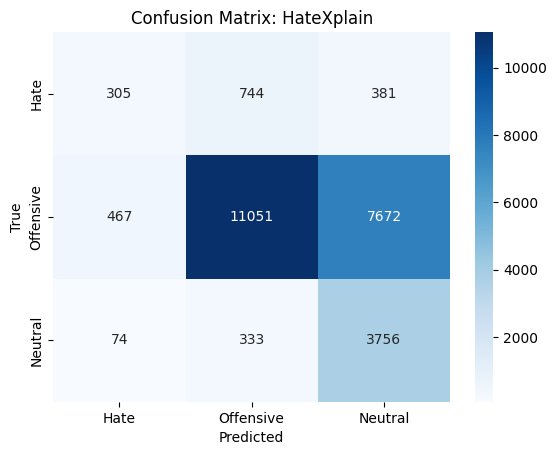

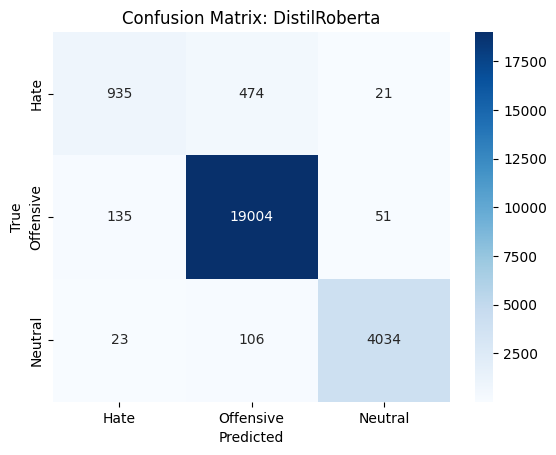

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Mapping for hatexplain and distilroberta
label_mapping = {'Hate': 0, 'Offensive': 1, 'Neutral': 2}

# Convert labels to numerical values for matching models
# df['true_label'] = df['label'].map(label_mapping)
df['hatexplain_numeric'] = df['hatexplain'].map(label_mapping)
df['distilroberta_numeric'] = df['distilroberta'].map(label_mapping)

# Calculate accuracy for facebook_roberta, hatexplain, and distilroberta
accuracy_hatexplain = accuracy_score(df['true_label'], df['hatexplain_numeric'])
accuracy_distilroberta = accuracy_score(df['true_label'], df['distilroberta_numeric'])

# Calculate F1 Scores (macro-averaged to account for multiple classes)
f1_hatexplain = f1_score(df['true_label'], df['hatexplain_numeric'], average='macro')
f1_distilroberta = f1_score(df['true_label'], df['distilroberta_numeric'], average='macro')

# Print Accuracy and F1 Scores
print(f"HateXplain - Accuracy: {accuracy_hatexplain}, F1 Score: {f1_hatexplain}")
print(f"DistilRoberta - Accuracy: {accuracy_distilroberta}, F1 Score: {f1_distilroberta}")

# Confusion Matrix for hatexplain
cm_hatexplain = confusion_matrix(df['true_label'], df['hatexplain_numeric'])
sns.heatmap(cm_hatexplain, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix: HateXplain")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion Matrix for distilroberta
cm_distilroberta = confusion_matrix(df['true_label'], df['distilroberta_numeric'])
sns.heatmap(cm_distilroberta, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix: DistilRoberta")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
df1 = df[df['true_label'] != 1]

<ipython-input-15-f18c94cdcb2f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cardiff_roberta_simplified'] = df1['cardiff_roberta'].map(label_mapping_cardiff)
<ipython-input-15-f18c94cdcb2f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cardiff_roberta_numeric'] = df1['cardiff_roberta_simplified'].map(label_mapping)


Cardiff Roberta (simplified) - Accuracy: 0.8839620954764885, F1 Score: 0.8455218882616224


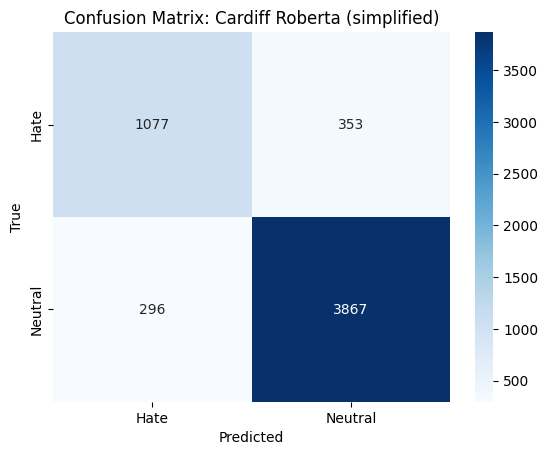

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and you want to simplify cardiff_roberta labels

# Mapping for cardiff_roberta, collapsing all hate categories into 'Hate'
label_mapping_cardiff = {
    "hate_gender": "Hate",
    "hate_race": "Hate",
    "hate_sexuality": "Hate",
    "hate_religion": "Hate",
    "hate_origin": "Hate",
    "hate_disability": "Hate",
    "hate_age": "Hate",
    "Neutral": "Neutral"
}

# Convert the 'cardiff_roberta' column to the new simplified label mapping
df1['cardiff_roberta_simplified'] = df1['cardiff_roberta'].map(label_mapping_cardiff)

# Convert the simplified labels to numeric values using the same mapping as before
label_mapping = {'Hate': 0, 'Offensive': 1, 'Neutral': 2}

# Map the simplified labels to numeric values
df1['cardiff_roberta_numeric'] = df1['cardiff_roberta_simplified'].map(label_mapping)

# Calculate accuracy, F1 score, and confusion matrix
accuracy_cardiff = accuracy_score(df1['true_label'], df1['cardiff_roberta_numeric'])
f1_cardiff = f1_score(df1['true_label'], df1['cardiff_roberta_numeric'], average='macro')

# Print accuracy and F1 score
print(f"Cardiff Roberta (simplified) - Accuracy: {accuracy_cardiff}, F1 Score: {f1_cardiff}")

# Confusion Matrix for cardiff_roberta
cm_cardiff = confusion_matrix(df1['true_label'], df1['cardiff_roberta_numeric'])
sns.heatmap(cm_cardiff, annot=True, fmt="d", cmap="Blues", xticklabels=['Hate', 'Neutral'], yticklabels=['Hate', 'Neutral'])
plt.title("Confusion Matrix: Cardiff Roberta (simplified)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<ipython-input-16-155fafa04a9c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['facebook_roberta_numeric'] = df1['facebook_roberta'].map(label_mapping)
<ipython-input-16-155fafa04a9c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dehatebert_numeric'] = df1['dehatebert'].map(label_mapping)


Facebook Roberta - Accuracy: 0.8975505095655283, F1 Score: 0.8753584749313444
Dehatebert - Accuracy: 0.9342034686214912, F1 Score: 0.9137624796161381


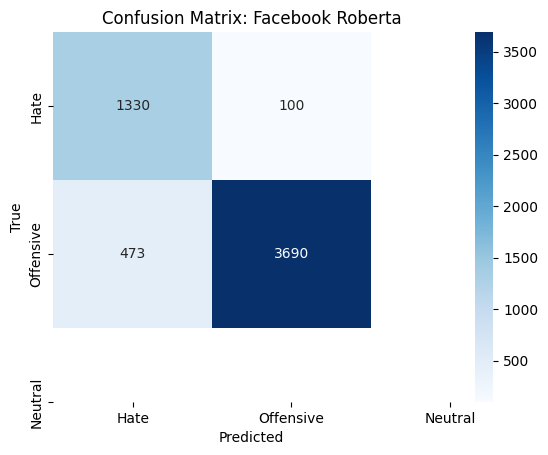

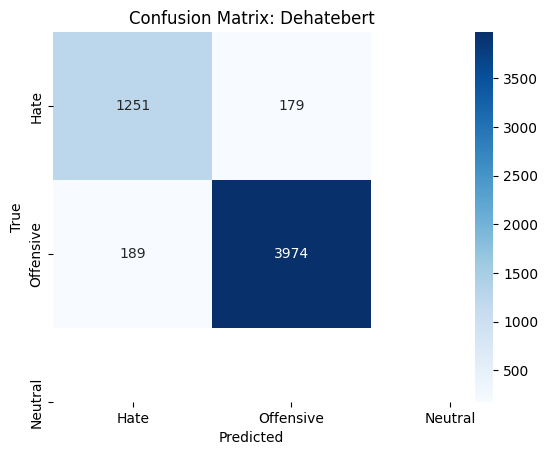

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# df1 = df[df['label'] != '1'] Already done above
label_mapping = {'Hate': 0, 'Offensive': 1, 'Neutral': 2}
# df1['true_label'] = df1['label'].map(label_mapping)
df1['facebook_roberta_numeric'] = df1['facebook_roberta'].map(label_mapping)
df1['dehatebert_numeric'] = df1['dehatebert'].map(label_mapping)
#accuracy
accuracy_facebook = accuracy_score(df1['true_label'], df1['facebook_roberta_numeric'])
accuracy_dehatebert = accuracy_score(df1['true_label'], df1['dehatebert_numeric'])

#F1
f1_facebook = f1_score(df1['true_label'], df1['facebook_roberta_numeric'], average='macro')
f1_dehatebert = f1_score(df1['true_label'], df1['dehatebert_numeric'], average='macro')
#Print scores
print(f"Facebook Roberta - Accuracy: {accuracy_facebook}, F1 Score: {f1_facebook}")
print(f"Dehatebert - Accuracy: {accuracy_dehatebert}, F1 Score: {f1_dehatebert}")

# Confusion Matrix for facebook_roberta
cm_facebook = confusion_matrix(df1['true_label'], df1['facebook_roberta_numeric'])
sns.heatmap(cm_facebook, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix: Facebook Roberta")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion Matrix for dehatebert
cm_dehatebert = confusion_matrix(df1['true_label'], df1['dehatebert_numeric'])
sns.heatmap(cm_dehatebert, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix: Dehatebert")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
